In [ ]:
# Import

In [ ]:
# Basic Libs
import os
import random
import numpy as np
import pandas as pd
import cv2

# Image Process
from skimage.data import imread
from skimage.morphology import label

# Model Framework
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Normalize, Compose
# from keras.models import *
# from keras.layers import *
# from keras.optimizers import *

# Helper Function
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.autograd import Variable

from src.preprocess import *
from src.pipeline import *

In [2]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    labels = label(img)
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def mask_overlay(image, mask, color=(0, 1, 0)):
    """
    Helper function to visualize mask on the top of the image
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(img, mask, title=None):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    mask = mask.numpy().transpose((1, 2, 0))
    mask = np.clip(mask, 0, 1)
    fig = plt.figure(figsize = (6,6))
    plt.imshow(mask_overlay(img, mask))
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [26]:
masks = pd.read_csv(os.path.join(input_dir,
                                 'train_ship_segmentations_v2.csv'))
#masks = masks.iloc[10000:12000]
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0], 'unique images found')
#masks.head()

231723 masks found
192556 unique images found


In [27]:
masks = masks.drop(masks[masks.EncodedPixels.isnull()].sample(70000,random_state=42).index)

# Preprocess

In [4]:
input_dir = '/datasets/ee285f-public/airbus_ship_detection/'
train_img_dir = '/datasets/ee285f-public/airbus_ship_detection/train_v2/'
test_img_dir = '/datasets/ee285f-public/airbus_ship_detection/test_v2/'

In [6]:
train_df = pd.read_csv(input_dir+'train_ship_segmentations_v2.csv')

In [5]:
train_df['isnan'] = train_df['EncodedPixels'].apply(checkNaN)
# Remove toxic image
train_df = train_df[train_df['ImageId'] != '6384c3e78.jpg']

In [6]:
# Remove 100000 Non-ship samples
train_df = train_df.sort_values('isnan', ascending=False)
train_df = train_df.iloc[100000:]

In [7]:
train_df['area'] = train_df['EncodedPixels'].apply(calc_area_for_rle)

In [8]:
train_df_isship = train_df[train_df['area'] > 0]

In [9]:
# Filter data by area less than 10
train_df_smallarea = train_df_isship['area'][train_df_isship['area'] < 10]

# Train Data Distribution

In [10]:
train_gp = train_df.groupby('ImageId').sum()
train_gp = train_gp.reset_index()
train_gp['class'] = train_gp['area'].apply(calc_class)

# Split Train-Valid

In [11]:
train, val = train_test_split(train_gp, test_size=0.01, stratify=train_gp['class'].tolist())

In [12]:
train_isship_list = train['ImageId'][train['isnan']==0].tolist()
train_isship_list = random.sample(train_isship_list, len(train_isship_list))
train_nanship_list = train['ImageId'][train['isnan']==1].tolist()
train_nanship_list = random.sample(train_nanship_list, len(train_nanship_list))

# Data Pipeline

In [13]:
BATCH_SIZE = 4
CAP = min(len(train_isship_list),len(train_nanship_list))
datagen = DataPipeline(train_isship_list, train_nanship_list, BATCH_SIZE, CAP, train_img_dir, train_df)

In [28]:
from sklearn.model_selection import train_test_split
unique_img_ids = masks.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.05, 
                 stratify = unique_img_ids['counts'],
                 random_state=42
                )
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

153636 training masks
8087 validation masks


In [29]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if 
                                    isinstance(c_row['EncodedPixels'], str) else
                                    0, 1)

In [30]:
class ShipDataset(Dataset):
    def __init__(self, in_df, transform=None, mode='train'):
        grp = list(in_df.groupby('ImageId'))
        self.image_ids =  [_id for _id, _ in grp] 
        self.image_masks = [m['EncodedPixels'].values for _,m in grp]
        self.transform = transform
        self.mode = mode
        self.img_transform = Compose([
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_ids)
               
    def __getitem__(self, idx):
        img_file_name = self.image_ids[idx]
        if self.mode == 'train':
            rgb_path = os.path.join(train_img_dir, img_file_name)
        else:
            rgb_path = os.path.join(test_img_dir, img_file_name)
        img = imread(rgb_path)
        mask = masks_as_image(self.image_masks[idx])
       
        if self.transform is not None:
            img, mask = self.transform(img, mask)

        if self.mode == 'train':
            #return self.to_float_tensor(img), self.to_float_tensor(mask)
            #eturn img, mask
            return self.img_transform(img), torch.from_numpy(np.moveaxis(mask, -1, 0)).float()
        else:
            return self.img_transform(img), str(img_file_name)

In [31]:
#Create dataset
dataset_valid = ShipDataset(valid_df)

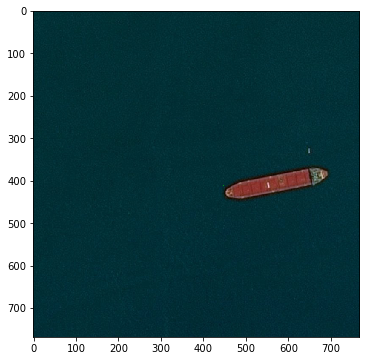

In [35]:
#show mask images
imshow(*dataset_valid[4])

# Define Model

In [ ]:
# inputs = Input(shape=(768,768,3))
# conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
# conv0 = BatchNormalization()(conv0)
# conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
# conv0 = BatchNormalization()(conv0)

# comp0 = AveragePooling2D((6,6))(conv0)
# conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
# conv1 = BatchNormalization()(conv1)
# conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
# conv1 = BatchNormalization()(conv1)
# conv1 = Dropout(0.4)(conv1)

# pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
# conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
# conv2 = BatchNormalization()(conv2)
# conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
# conv2 = BatchNormalization()(conv2)
# conv2 = Dropout(0.4)(conv2)

# pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
# conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
# conv3 = BatchNormalization()(conv3)
# conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
# conv3 = BatchNormalization()(conv3)
# conv3 = Dropout(0.4)(conv3)

# pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
# conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
# conv4 = BatchNormalization()(conv4)
# conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
# conv4 = BatchNormalization()(conv4)
# conv4 = Dropout(0.4)(conv4)

# pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
# conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
# conv5 = BatchNormalization()(conv5)
# conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
# conv5 = BatchNormalization()(conv5)

# upcv6 = UpSampling2D(size=(2,2))(conv5)
# upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
# upcv6 = BatchNormalization()(upcv6)
# mrge6 = concatenate([conv4, upcv6], axis=3)
# conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
# conv6 = BatchNormalization()(conv6)
# conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
# conv6 = BatchNormalization()(conv6)

# upcv7 = UpSampling2D(size=(2,2))(conv6)
# upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
# upcv7 = BatchNormalization()(upcv7)
# mrge7 = concatenate([conv3, upcv7], axis=3)
# conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
# conv7 = BatchNormalization()(conv7)
# conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
# conv7 = BatchNormalization()(conv7)

# upcv8 = UpSampling2D(size=(2,2))(conv7)
# upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
# upcv8 = BatchNormalization()(upcv8)
# mrge8 = concatenate([conv2, upcv8], axis=3)
# conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
# conv8 = BatchNormalization()(conv8)
# conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
# conv8 = BatchNormalization()(conv8)

# upcv9 = UpSampling2D(size=(2,2))(conv8)
# upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
# upcv9 = BatchNormalization()(upcv9)
# mrge9 = concatenate([conv1, upcv9], axis=3)
# conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
# conv9 = BatchNormalization()(conv9)
# conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
# conv9 = BatchNormalization()(conv9)

# dcmp10 = UpSampling2D((6,6),interpolation='bilinear')(conv9)
# mrge10 = concatenate([dcmp10, conv0], axis=3)
# conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
# conv10 = BatchNormalization()(conv10)
# conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
# conv10 = BatchNormalization()(conv10)
# conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)

# model = Model(inputs=inputs, outputs=conv11)

In [17]:
class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(3, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x

if __name__ == '__main__':
    net = UNet().cuda()
    print(net)

    test_x = Variable(torch.cuda.FloatTensor(1, 3, 1024, 1024))
    out_x = net(test_x)

    print(out_x.size())

UNet(
  (down_block1): UNet_down_block(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block2): UNet_down_block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [18]:
model = UNet()

# Loss function

In [19]:
class LossBinary:
    """
     Implementation from  https://github.com/ternaus/robot-surgery-segmentation
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1.0).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

# Validation routine

In [20]:
def validation(model: nn.Module, criterion, valid_loader):
    print("Validation on hold-out....")
    model.eval()
    losses = []
    jaccard = []
    for inputs, targets in valid_loader:
        inputs = variable(inputs, volatile=True)
        targets = variable(targets)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        losses.append(loss.data[0])
        jaccard += [get_jaccard(targets, (outputs > 0).float()).data[0]]

    valid_loss = np.mean(losses)  # type: float

    valid_jaccard = np.mean(jaccard)

    print('Valid loss: {:.5f}, jaccard: {:.5f}'.format(valid_loss, valid_jaccard))
    metrics = {'valid_loss': valid_loss, 'jaccard_loss': valid_jaccard}
    return metrics

def get_jaccard(y_true, y_pred):
    epsilon = 1e-15
    intersection = (y_pred * y_true).sum(dim=-2).sum(dim=-1).sum(dim = -1)
    union = y_true.sum(dim=-2).sum(dim=-1).sum(dim=-1) + y_pred.sum(dim=-2).sum(dim=-1).sum(dim = -1)

    return (intersection / (union - intersection + epsilon)).mean()

In [21]:
# some helper functions
def variable(x, volatile=False):
    if isinstance(x, (list, tuple)):
        return [variable(y, volatile=volatile) for y in x]
    return cuda(Variable(x, volatile=volatile))

def cuda(x):
    return x.cuda() if torch.cuda.is_available() else x

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()

# Train

In [22]:
# main train routine
# Implementation from  https://github.com/ternaus/robot-surgery-segmentation
def train(lr, model, criterion, train_loader, valid_loader, validation, init_optimizer, n_epochs=1, fold=1):
    optimizer = init_optimizer(lr)
    #model = nn.DataParallel(model, device_ids=None)
    if torch.cuda.is_available():
        model.cuda()
       
    model_path = Path('model_{fold}.pt'.format(fold=fold))
    if model_path.exists():
        state = torch.load(str(model_path))
        epoch = state['epoch']
        step = state['step']
        model.load_state_dict(state['model'])
        print('Restored model, epoch {}, step {:,}'.format(epoch, step))
    else:
        epoch = 1
        step = 0

    save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))


    report_each = 50
    log = open('train_{fold}.log'.format(fold=fold),'at', encoding='utf8')
    valid_losses = []
    for epoch in range(epoch, n_epochs + 1):
        model.train()
        random.seed()
        tq = tqdm(total=len(train_loader) *  BATCH_SIZE)
        tq.set_description('Epoch {}, lr {}'.format(epoch, lr))
        losses = []
        tl = train_loader
        try:
            mean_loss = 0
            for i, (inputs, targets) in enumerate(tl):
                inputs, targets = variable(inputs), variable(targets)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                batch_size = inputs.size(0)
                loss.backward()
                optimizer.step()
                step += 1
                tq.update(batch_size)
                losses.append(loss.data[0])
                mean_loss = np.mean(losses[-report_each:])
                tq.set_postfix(loss='{:.5f}'.format(mean_loss))
                if i and i % report_each == 0:
                    write_event(log, step, loss=mean_loss)
            write_event(log, step, loss=mean_loss)
            tq.close()
            save(epoch + 1)
            valid_metrics = validation(model, criterion, valid_loader)
            write_event(log, step, **valid_metrics)
            valid_loss = valid_metrics['valid_loss']
            valid_losses.append(valid_loss)
        except KeyboardInterrupt:
            tq.close()
            print('Ctrl+C, saving snapshot')
            save(epoch)
            print('done.')
            return
    

In [23]:
def make_loader(in_df, batch_size, shuffle=False, transform=None):
        return DataLoader(
            dataset=ShipDataset(in_df, transform=transform),
            shuffle=shuffle,
            num_workers = 0,
            batch_size = batch_size,
            pin_memory=torch.cuda.is_available()
        )

train_loader = make_loader(train_df, batch_size =  BATCH_SIZE, shuffle=True, transform=None)
valid_loader = make_loader(valid_df, batch_size = BATCH_SIZE / 2, transform=None)

NameError: name 'ShipDataset' is not defined

In [ ]:
model = UNet()
model_path ='model_1.pt'
state = torch.load(str(model_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model.load_state_dict(state)
if torch.cuda.is_available():
    model.cuda()

model.eval()

# Train

In [17]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='../log', histogram_freq=0, write_graph=True, write_images=True)
saveCallBack = keras.callbacks.ModelCheckpoint('../models/checkpoint_new.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
CallBackList = [tbCallBack, saveCallBack]

In [ ]:
history = model.fit_generator(datagen, steps_per_epoch = 1000, epochs = 5, callbacks=CallBackList)

Epoch 1/5
1000/1000 [==============================] - 121s 121ms/step - loss: 0.1577
Epoch 2/5
1000/1000 [==============================] - 114s 114ms/step - loss: 0.0123
Epoch 3/5
1000/1000 [==============================] - 113s 113ms/step - loss: 0.0082
Epoch 4/5
 988/1000 [============================>.] - ETA: 1s - loss: 0.0076